# Appendix B
## Quantum Dynamics of the XY Heisenberg Model using Trotterization and Constant-Depth Circuits

This notebook demonstrates how to generate constant-depth circuits for dynamic simulation of the XY Heisenberg Model. First, circuits for different time-steps are prepared using Suzuki-Trotter decomposition. These circuits are then transformed into constant-depth circuits with optimized parameters for the given range of time-steps. 

The concept of constant-depth circuits was originally proposed in the [Constant-depth circuits for dynamic simulations of materials on quantum computers](https://jmsh.springeropen.com/articles/10.1186/s41313-022-00043-x) paper.

The number of spins in the chain (number of qubits) is arbitrary. The complete code is available on [Github](https://github.com/pranavi-jain/pennylane/tree/main/Heisenberg%20Model%20Dynamics).

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
from scipy.linalg import norm

# Qiskit import
import qiskit as qc
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

# Pennylane import
import pennylane as qml

### System parameters
Defining the parameters of the system and the simulation we wish to run. Here, we will be performing a quantum quench of an XY model. Set the number of desired qubits; the coupling constant Jx; the coulping constant Jy; the time-step size; the number of time-steps; and the number of shots for performing experiments on the quantum simulator or the real quantum hardware.

In [31]:
## Define simulation parameters for XY model

N = 5   # number of spins/qubits

# XY model Simulation parameters
Jx = -1.0           # coupling strength Jx, in meV
Jy = -1.0           # coupling strength Jy, in meV
delta_t = 0.025     # time-step size, in fs
num_steps = 40      # number of time steps
shots = 8192        # number of shots for circuit execution

### Instantiate a Qiskit Runtime Service to run code on IBM hardware

In [ ]:
from key import token_520, token_513

instance_520 = "usc/ee520-g/ee520-project"
instance_513 = "usc/phys513/phys513p"


## Define qiskit runtime service and backends

QiskitRuntimeService.save_account(channel="ibm_quantum", token=token_513, overwrite=True)

# To access saved credentials for the IBM quantum channel and select an instance
service = QiskitRuntimeService(channel="ibm_quantum", instance=instance_513)
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=N)
print(f"Using backend: {backend}")

### Define the required simulators and QPU devices for pennylane

In [32]:
## Define the pennylane devices

dev_qubit = qml.device("default.qubit", wires=N)
dev_mixed = qml.device("default.mixed", wires=N)
dev_lightning = qml.device('lightning.qubit', wires=N) 
# dev_gpu = qml.device('lightning.gpu', wires=N) 
dev_aer = qml.device("qiskit.remote", wires=N, backend=AerSimulator())
# dev_qiskit = qml.device("qiskit.remote", wires=N, backend=backend, resilience_level=1, optimization_level=1)

### Instantiate global variables to store final results

In [33]:
## Define global variables to store Trotter and constant-depth results

trotter_sim_results = []
trotter_sim_cnots = []
trotter_aer_sim_results = []
trotter_aer_sim_cnots = []
trotter_ibm_results = []
trotter_ibm_cnots = []

cd_sim_results = []
cd_sim_cnots = []
cd_aer_sim_results = []
cd_aer_sim_cnots = []
cd_ibm_results = []
cd_ibm_cnots = []

## Dynamics simulation using Trotterization
In this section, we generate high-level circuits using Suzuki-Trotter decomposition and simulate the dynamics of XY model. These circuits will also be used to create the constant-depth circuits. As expected, these circuits will not be constant in depth with increasing numbers of time-steps.

In [12]:
from helper import evolution_circuit_XY


## Define the Trotter circuit for the TFIM Hamiltonian

def trotter_ckt(t, Jx, Jy, delta_t, N):
    # initialize to the ground state of ZZ, i.e., the Neel state
    for q in range(N):
        if(q%2 != 0):
            qml.PauliX(q)
    # circuit for evolution under the TFIM Hamiltonian
    evolution_circuit_XY(t, Jx, Jy, delta_t, N)
    # measuring the expectation value of the PauliX operators
    return [qml.expval((-1)**i * qml.PauliZ(wires=i)) for i in range(N)]

(<Figure size 2300x400 with 1 Axes>, <Axes: >)

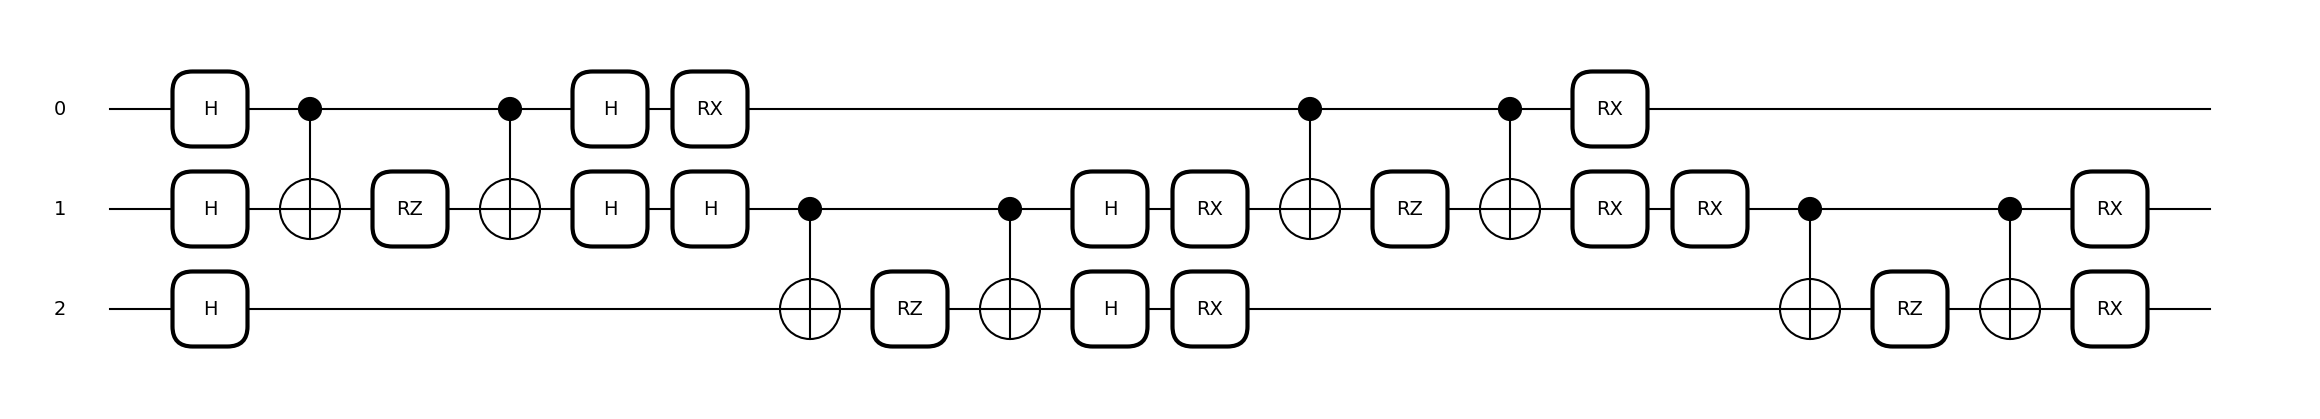

In [9]:
## Drawing a circuit for a single time-step of the TFIM Hamiltonian Simulation

qml.draw_mpl(evolution_circuit_XY)(1, Jx, Jy, delta_t, N)

### Simulating trotter circuit on Pennylane's default-qubit simulator

In [34]:
## Simulating the XY model Hamiltonian using Trotter decomposition

trotter_sim_results = []    # Reinitialize the results list
trotter_sim_cnots = []  # Reinitialize the CNOT counts list
target_unitaries = []
trotter_sim_ckt = qml.QNode(trotter_ckt, device=dev_qubit)


for t in range(num_steps + 1):
    # Generate target unitary matrix for given time step
    target_unitaries.append(qml.matrix(trotter_sim_ckt)(t, Jx, Jy, delta_t, N))
    # Simulate the Trotter circuit
    exp_vals = trotter_sim_ckt(t, Jx, Jy, delta_t, N)
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    # Store the results
    trotter_sim_results.append(result)
    trotter_sim_cnots.append(qml.specs(trotter_sim_ckt)(t, Jx, Jy, delta_t, N)["resources"].gate_types['CNOT'])


print(trotter_sim_results)

[np.float64(1.0), np.float64(0.981629829437594), np.float64(0.9275728248207509), np.float64(0.8409218497753805), np.float64(0.7266106968292083), np.float64(0.5910982147285744), np.float64(0.44195618619875265), np.float64(0.28738857573964827), np.float64(0.1357143073012348), np.float64(-0.0051519202111168115), np.float64(-0.12818627358004808), np.float64(-0.22767772472403647), np.float64(-0.29955766286910973), np.float64(-0.34161595353447305), np.float64(-0.3535900459328644), np.float64(-0.3371224462014144), np.float64(-0.2955908786005009), np.float64(-0.2338241319323719), np.float64(-0.15772433885023093), np.float64(-0.07382273070374092), np.float64(0.011199679841233457), np.float64(0.09099281157764118), np.float64(0.1599860552595947), np.float64(0.2137735048471648), np.float64(0.24940932242763103), np.float64(0.26559308854791286), np.float64(0.262732781116782), np.float64(0.24288165875408713), np.float64(0.20955419945525605), np.float64(0.1674347473284557), np.float64(0.12200005968269

### Simulating trotter circuits on IBM's Aer_Simulator

In [35]:
## Simulating the XY model Hamiltonian using Trotter decomposition - Qiskit AerSimulator

trotter_aer_sim_results = []   # Reinitialize the results list
trotter_aer_sim_cnots = []  # Reinitialize the CNOT counts list
trotter_aer_sim_ckt = qml.QNode(trotter_ckt, device=dev_aer)


for t in range(num_steps + 1):
    # Simulate the Trotter circuit
    exp_vals = trotter_aer_sim_ckt(t, Jx, Jy, delta_t, N)
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    # Store the results
    trotter_aer_sim_results.append(result)
    trotter_aer_sim_cnots.append(qml.specs(trotter_aer_sim_ckt)(t, Jx, Jy, delta_t, N)["resources"].gate_types['CNOT'])

print(trotter_sim_results)

/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If t

[np.float64(1.0), np.float64(0.981629829437594), np.float64(0.9275728248207509), np.float64(0.8409218497753805), np.float64(0.7266106968292083), np.float64(0.5910982147285744), np.float64(0.44195618619875265), np.float64(0.28738857573964827), np.float64(0.1357143073012348), np.float64(-0.0051519202111168115), np.float64(-0.12818627358004808), np.float64(-0.22767772472403647), np.float64(-0.29955766286910973), np.float64(-0.34161595353447305), np.float64(-0.3535900459328644), np.float64(-0.3371224462014144), np.float64(-0.2955908786005009), np.float64(-0.2338241319323719), np.float64(-0.15772433885023093), np.float64(-0.07382273070374092), np.float64(0.011199679841233457), np.float64(0.09099281157764118), np.float64(0.1599860552595947), np.float64(0.2137735048471648), np.float64(0.24940932242763103), np.float64(0.26559308854791286), np.float64(0.262732781116782), np.float64(0.24288165875408713), np.float64(0.20955419945525605), np.float64(0.1674347473284557), np.float64(0.12200005968269

/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


### Running trotter circuits on IBM Backends

In [ ]:
## Simulating the TFIM Hamiltonian using Trotter decomposition - IBM Backend

trotter_ibm_results = []   # Reinitialize the results list
trotter_ibm_cnots = []  # Reinitialize the CNOT counts list
trotter_ibm_ckt = qml.QNode(trotter_ckt, device=dev_qiskit)


'''TBD: Define session and collect job ids'''
for t in range(num_steps + 1):
    # Simulate the Trotter circuit
    exp_vals = trotter_ibm_ckt(t, Jx, Jy, delta_t, N)
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    # Store the results
    trotter_ibm_results.append(result)
    trotter_ibm_cnots.append(qml.specs(trotter_ibm_ckt)(t, Jx, Jy, delta_t, N)["resources"].gate_types['CNOT'])

print(trotter_sim_results)

## Dynamics simulation using constant-depth circuits
In this section, we generate constant-depth circuits for the given range of time-steps and simulate the dynamics of XY model. These curcuits use matchgates and as expected, these circuits are constant in depth with increasing numbers of time-steps.

### Define functions to generate circuits using matchgates
The structure of these matchgate circuits is adopted from the Appendix given in the [Constant-depth circuits for dynamic simulations of materials on quantum computers](https://jmsh.springeropen.com/articles/10.1186/s41313-022-00043-x) paper.

In [36]:
from matchgates_xy import make_layertype1, make_layertype2


## Define the matchgate circuit for N qubits

def make_MGC(N, params):
    for l in range(N):
        # add layer_type1
        if l % 2 == 0:
            make_layertype1(N, params)
        # add layer_type2
        else:
            make_layertype2(N, params)
    return [qml.expval((-1)**i * qml.PauliZ(wires=i)) for i in range(N)]

0: ──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)──RX(1.57)──────────────────────────────────────╭● ···
1: ──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)──RX(1.57)─╰X ···
2: ──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)──RX(1.57)─╭● ···
3: ──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)──RX(1.57)──────────────────────────────────────╰X ···

0: ··· ──RX(0.10)─╭●──RX(-1.57)──────────────────────────────────────┤  <1.00*Z> 
1: ··· ──RZ(0.10)─╰X──RX(-1.57)──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)─┤  <-1.00*Z>
2: ··· ──RX(0.10)─╭●──RX(-1.57)──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)─┤  <1.00*Z> 
3: ··· ──RZ(0.10)─╰X──RX(-1.57)──────────────────────────────────────┤  <-1.00*Z>
(<Figure size 2300x500 with 1 Axes>, <Axes: >)


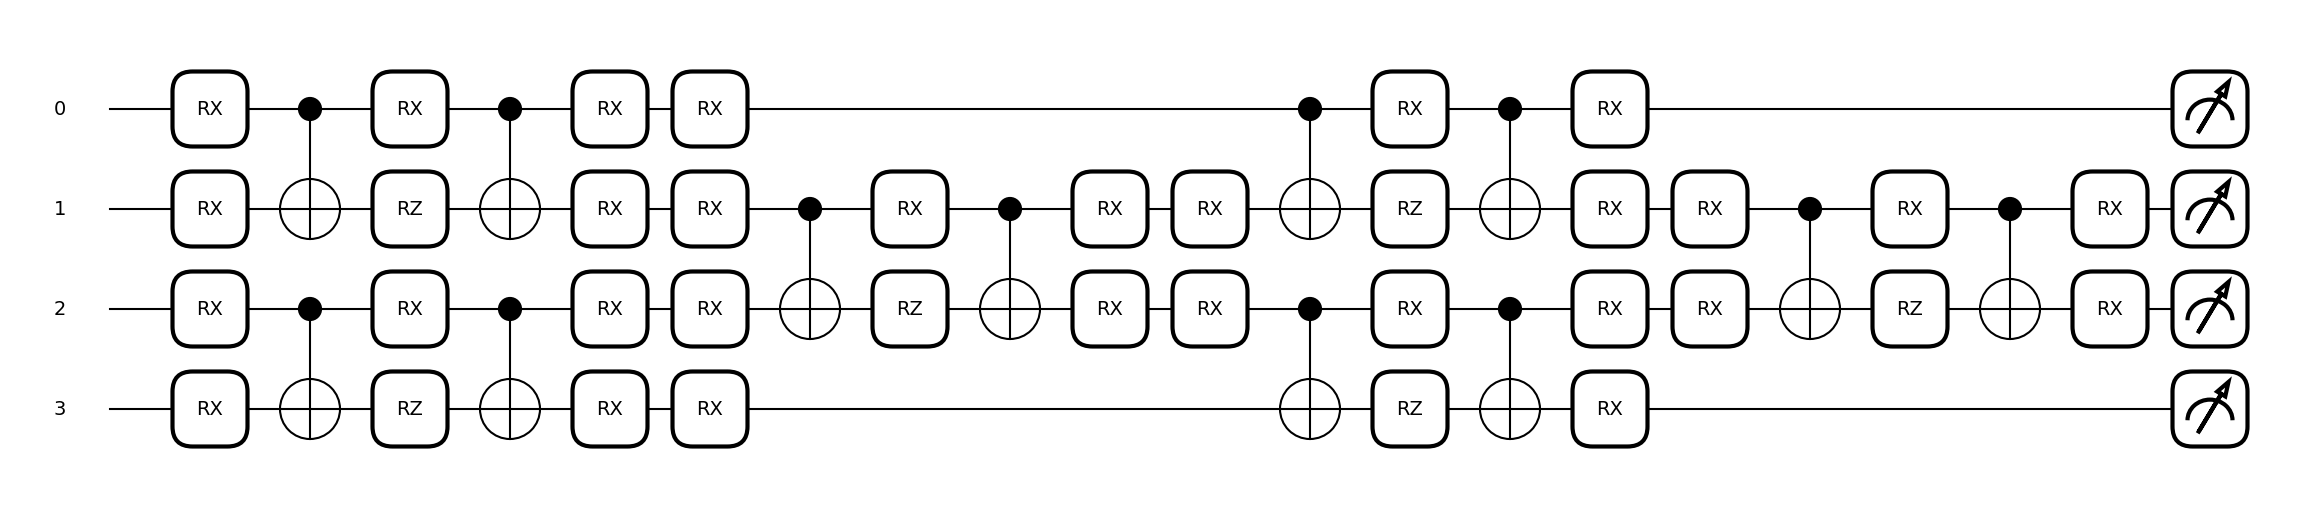

In [37]:
## Draw a matchgate circuit with random parameters (Testing)

print(qml.draw(make_MGC)(4, [0.1] * 2))     # draw() shows the parameter values
print(qml.draw_mpl(make_MGC)(4, [0.1] * 2))

### Optimize parameters and generate constant-depth circuits for all time-steps
The constant-depth circuits are generated by using optimal parameters for the matchgate circuits. The parameters are optimizated by minimizing a cost function that compares the distance between two unitary matrices - a target unitary obtained from high-level trotter circuits, and a unitary matrix obtained from the matchgate circuit structure.

In [38]:
## Define the cost function caluclating the distance (= 1 - fidelity) between
## the target and current unitary matrices

matchgate_ckt = qml.QNode(make_MGC, device=dev_qubit)


def cost_function(params):
    current_unitary = qml.matrix(matchgate_ckt)(N, params)
    ## Calculate Frobenius distance
    # distance = norm(target_unitary - current_unitary, 'fro')
    distance = np.abs(
        1 - np.abs(np.sum(np.multiply(current_unitary, np.conj(target_unitary))))
        / current_unitary.shape[0]
    )
    return distance

In [39]:
## Find the best parameters for matchgates for each time step

num_runs = 6  # Number of times minimization is run
tolerance = 1e-10  # Target final distance
final_params = []

for t in range(num_steps + 1):
    # Get the target unitary from Qiskit
    target_unitary = target_unitaries[t]

    # Set the initial parameters
    init_params = [np.pi/2] * 2
    best_distance = np.inf

    # Multi-start optimization loop
    for _ in range(num_runs):
        # Random initial guess
        # init_params = 2 * np.pi * (np.random.rand(len(init_params)) - 0.5)
        # init_params = np.array([random.random() for _ in range(len(init_params))])

        # Minimize the cost function
        result = minimize(cost_function, init_params, tol=tolerance)

        if result.fun < best_distance:
            best_distance = result.fun
            best_params = result.x

        # Early stopping
        if best_distance < tolerance:
            break

    # Save the best found parameters
    final_params.append(best_params)
    print(f"Time step {t}: best achieved distance {best_distance:.2e}")

Time step 0: best achieved distance 1.00e+00
Time step 1: best achieved distance 7.76e-01
Time step 2: best achieved distance 7.72e-01
Time step 3: best achieved distance 7.86e-01
Time step 4: best achieved distance 7.93e-01
Time step 5: best achieved distance 8.00e-01
Time step 6: best achieved distance 8.09e-01
Time step 7: best achieved distance 8.56e-01
Time step 8: best achieved distance 8.26e-01
Time step 9: best achieved distance 8.41e-01
Time step 10: best achieved distance 8.48e-01
Time step 11: best achieved distance 8.52e-01
Time step 12: best achieved distance 8.55e-01
Time step 13: best achieved distance 8.56e-01
Time step 14: best achieved distance 8.56e-01
Time step 15: best achieved distance 8.56e-01
Time step 16: best achieved distance 8.54e-01
Time step 17: best achieved distance 8.51e-01
Time step 18: best achieved distance 8.46e-01
Time step 19: best achieved distance 8.40e-01
Time step 20: best achieved distance 7.40e-01
Time step 21: best achieved distance 7.30e-0

In [40]:
## Define function to generate constant-depth circuits

def constant_depth_circuit(N, params):
    # initialize to the ground state of ZZ, i.e., the Neel state
    for q in range(N):
        if(q%2 != 0):
            qml.PauliX(q)
    # add matchgate circuit
    for l in range(N):
        # add layer_type1
        if l % 2 == 0:
            make_layertype1(N, params)
        # add layer_type2
        else:
            make_layertype2(N, params)
    # measuring the expectation value of the PauliX operators
    return [qml.expval((-1)**i * qml.PauliZ(wires=i)) for i in range(N)]

### Simulating and executing constant-depth circuits on the following devices:
1. Pennylane's default-qubit simulator
2. IBM's Aer_Simulator
3. IBM's Backend (QPU)

In [41]:
## Define function to get results from the constant-depth circuits

def get_results(ckt, N, final_params, num_steps):
    results = []
    cnots = []
    for t in range(num_steps + 1):
        # Simulate the constant-depth circuit
        exp_vals = ckt(N, final_params[t])
        # Taking the mean of the expectation values = average magnetization
        result = np.mean(exp_vals)
        results.append(result)
        cnots.append(qml.specs(ckt)(N, final_params[t])["resources"].gate_types['CNOT'])
    return results, cnots

In [42]:
## 1. Simulating the constant-depth circuits for given time-steps on pennylane simulator

cd_sim_results = []   # Reinitialize the results list
cd_sim_cnots = []  # Reinitialize the CNOT counts list
cd_sim_ckt = qml.QNode(constant_depth_circuit, device=dev_qubit)

cd_sim_results, cd_sim_cnots = get_results(cd_sim_ckt, N, final_params, num_steps)

print(cd_sim_results)

[np.float64(0.9999999999999998), np.float64(-0.053658037599257205), np.float64(0.11049620359371573), np.float64(-0.07722738708111936), np.float64(-0.07269509376131618), np.float64(-0.04800876809866687), np.float64(0.02590054862148704), np.float64(0.15799679529831745), np.float64(0.4501608894569932), np.float64(0.10043925899007258), np.float64(0.21953443362818628), np.float64(0.2361014075751909), np.float64(0.195673288705078), np.float64(0.1365869829383725), np.float64(0.08866034295537466), np.float64(0.07201091028761415), np.float64(0.1010941092643046), np.float64(0.18861804564973114), np.float64(0.3461879832396324), np.float64(0.5805100875800309), np.float64(0.2013897022677385), np.float64(0.2012063028596464), np.float64(0.200672628789159), np.float64(0.19926545008520197), np.float64(0.1956837496722384), np.float64(0.18803198785329553), np.float64(0.1753533321237965), np.float64(0.15980928047859094), np.float64(0.14651009779380558), np.float64(0.1401816415461977), np.float64(0.1429420

In [43]:
## 2. Simulating the constant-depth circuits on IBM AerSimulator

cd_aer_sim_results = []   # Reinitialize the results list
cd_aer_sim_cnots = []  # Reinitialize the CNOT counts list
cd_aer_sim_ckt = qml.QNode(constant_depth_circuit, device=dev_aer)

cd_aer_sim_results, cd_aer_sim_cnots = get_results(cd_aer_sim_ckt, N, final_params, num_steps)

print(cd_aer_sim_results)

/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If t

[np.float64(1.0), np.float64(-0.04453125), np.float64(0.109375), np.float64(-0.08046875), np.float64(-0.08125), np.float64(-0.046875), np.float64(0.01796875), np.float64(0.19765625), np.float64(0.44921875), np.float64(0.10546875), np.float64(0.21953125), np.float64(0.2328125), np.float64(0.19140625), np.float64(0.13671875), np.float64(0.09375), np.float64(0.090625), np.float64(0.10390625), np.float64(0.18671875), np.float64(0.36015625), np.float64(0.55859375), np.float64(0.203125), np.float64(0.1953125), np.float64(0.20625), np.float64(0.18984375), np.float64(0.19765625), np.float64(0.17890625), np.float64(0.184375), np.float64(0.16953125), np.float64(0.1453125), np.float64(0.1375), np.float64(0.14375), np.float64(0.7125), np.float64(0.74296875), np.float64(0.79375), np.float64(0.7734375), np.float64(0.778125), np.float64(0.76171875), np.float64(0.75), np.float64(0.72890625), np.float64(0.71015625), np.float64(0.6453125)]


/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


In [ ]:
## 3. Simulating the constant-depth circuits on IBM Backend

cd_ibm_results = []   # Reinitialize the results list
cd_ibm_cnots = []  # Reinitialize the CNOT counts list
cd_ibm_ckt = qml.QNode(constant_depth_circuit, device=dev_qiskit)

'''TBD: Define session and collect job ids'''
cd_ibm_results, cd_ibm_cnots = get_results(cd_ibm_ckt, N, final_params, num_steps)

print(cd_ibm_results)

## Plot Results
In this section, we plot the following results:
1. Average Magnetization vs. Time-steps,
2. Number of CNOTS in circuit vs. Time-steps.
A single time-step is equal to **3fs**.

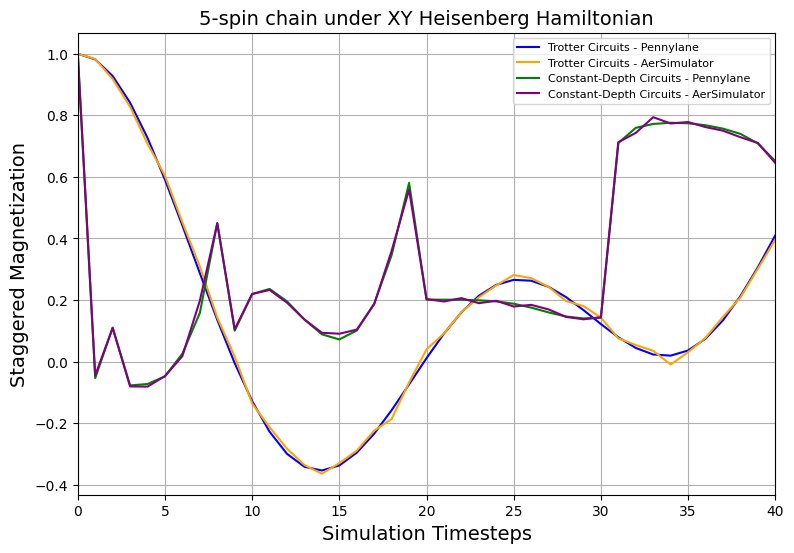

In [44]:
## Plotting the results - Average Magnetization vs. time-steps

plt.figure(figsize=(9, 6))
plt.plot(trotter_sim_results, label="Trotter Circuits - Pennylane", color="blue")
plt.plot(trotter_aer_sim_results, label="Trotter Circuits - AerSimulator", color="orange")
# plt.plot(trotter_ibm_results, label=f"Trotter Circuits - {backend}", color="red")
plt.plot(cd_sim_results, label="Constant-Depth Circuits - Pennylane", color="green")
plt.plot(cd_aer_sim_results, label="Constant-Depth Circuits - AerSimulator", color="purple")
plt.xlim(0,num_steps)
plt.xlabel("Simulation Timesteps", fontsize=14)
plt.ylabel("Staggered Magnetization", fontsize=14)
plt.title(f"{N}-spin chain under XY Heisenberg Hamiltonian", fontsize=14)
plt.grid()
plt.legend(fontsize=8)
plt.show()
# plt.savefig(f'{N}q_TFIM_sim_pennylane.svg', dpi=500)

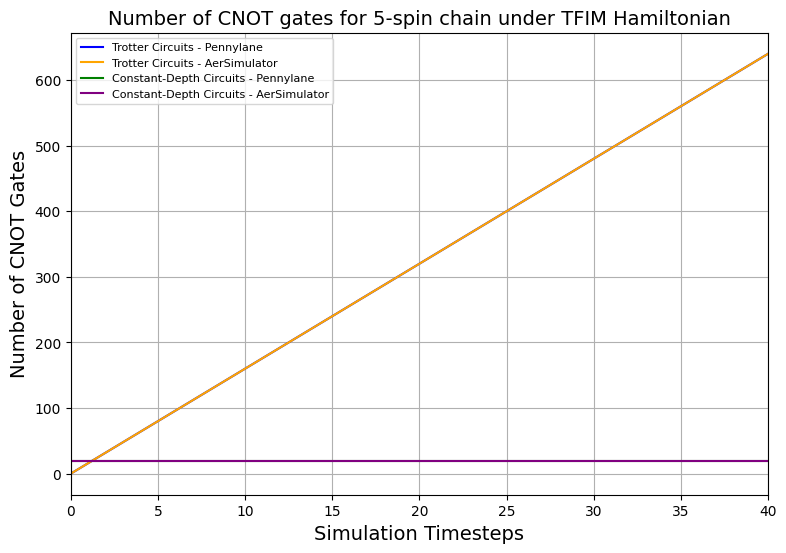

In [45]:
## Plotting the circuit depth vs. time-steps

plt.figure(figsize=(9, 6))
plt.plot(trotter_sim_cnots, label="Trotter Circuits - Pennylane", color="blue")
plt.plot(trotter_aer_sim_cnots, label="Trotter Circuits - AerSimulator", color="orange")
# plt.plot(trotter_ibm_cnots, label=f"Trotter Circuits - {backend}", color="red")
plt.plot(cd_sim_cnots, label="Constant-Depth Circuits - Pennylane", color="green")
plt.plot(cd_aer_sim_cnots, label="Constant-Depth Circuits - AerSimulator", color="purple")
plt.xlim(0, num_steps)
# plt.ylim(-1.0, 1.0)
plt.xlabel("Simulation Timesteps", fontsize=14)
plt.ylabel("Number of CNOT Gates", fontsize=14)
plt.title(f"Number of CNOT gates for {N}-spin chain under TFIM Hamiltonian", fontsize=14)
plt.legend(fontsize=8)
plt.grid()
plt.show()
# plt.savefig(f'{N}q_TFIM_sim_pennylane.svg', dpi=500)

<hr/>